In [13]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

### Example data

A small data set with acc=accruals and agr=asset growth, monthly data since 2010, roughly 2,000 stocks per month.

In [2]:
data = pd.read_csv("https://www.dropbox.com/s/012c6y4gxsxss6y/ghz.csv?dl=1", parse_dates=["date"])
data.permno = data.permno.astype(int)
data['date'] = data.date.dt.to_period('M')
data = data.sort_values(by=['permno', 'date']).reset_index(drop=True)
data.head()

,permno,date,ret,acc,agr
0,10025,2012-10,0.055125,-0.028995,0.184931
1,10025,2012-11,-0.053652,-0.028995,0.184931
2,10025,2012-12,-0.020992,-0.028995,0.184931
3,10025,2013-01,0.086949,-0.028995,0.184931
4,10025,2013-02,0.095527,-0.028995,0.184931


### View cross-sections

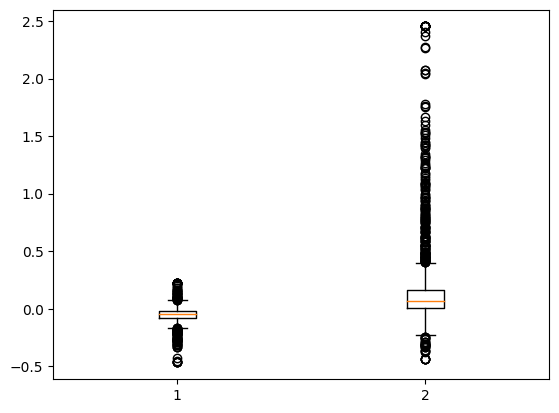

In [12]:
date = input("Input a date: ")
df = data[data.date==date]
fig = plt.boxplot([df.acc, df.agr]) 

### Standardize cross-sections

In [14]:
data.agr = np.log(1+data.agr)

def winsorize(ser):
    return ser.clip(lower=ser.quantile(0.01), upper=ser.quantile(0.99))


for char in ["acc", "agr"]:
    data[char] = data.groupby("date")[char].apply(winsorize)
    data[char] = data.groupby("date")[char].apply(lambda x: (x-x.mean()) / x.std())

### Fama-MacBeth regressions

In [15]:
def xreg(df):
    model = smf.ols("ret ~ acc + agr", data=df)
    result = model.fit()
    return result.params

fm = data.groupby('date').apply(xreg)
fm.head()

,Intercept,acc,agr
date,,,
2010-01,-0.031819,0.003054,-0.003491
2010-02,0.044172,-0.006460,-0.001232
2010-03,0.077351,0.004839,-0.007581
2010-04,0.049888,-0.010579,-0.002766
2010-05,-0.075477,0.000646,0.002947


### t tests with Newey-West standard errors

In [16]:
def ttest(name, data):
    model = smf.ols(name + " ~ 1", data=data)
    result = model.fit(cov_type='HAC', cov_kwds={"kernel": "bartlett", "maxlags": 12})
    return result.summary().tables[1]

print(ttest('acc', data=fm))
print(ttest('agr', data=fm))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.001      0.237      0.812      -0.001       0.002
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0008      0.001     -1.305      0.192      -0.002       0.000


### Fama-French factors

In [68]:
ff = pdr("F-F_Research_Data_Factors", "famafrench", start=2000)[0] / 100
data = data.merge(ff, left_on='date', right_index=True, how="left") 
data = data.rename(columns={"Mkt-RF": "Mkt_RF"})
data["ret_RF"] = data.ret - data.RF

### Rolling window betas

In [76]:
def rolling_betas(df):
    n = df.shape[0]
    if n >= 24:
        data = df.set_index("date") 
        model = RollingOLS.from_formula(
            "ret_RF ~ Mkt_RF + SMB + HML",
            window=min(n, 60),
            min_nobs=24,
            expanding=True,
            data=data
        )
        result = model.fit()
        return result.params[['Mkt_RF', 'SMB', 'HML']].dropna()
    else:
        pass
    
    
betas = data.groupby("permno").apply(rolling_betas)
betas.head()

Mkt_RF       SMB       HML
permno date                                 
10026  2011-12  0.174161  1.804534 -0.241938
       2012-01  0.114215  1.730630 -0.122765
       2012-02  0.125485  1.700585 -0.119297
       2012-03  0.154238  1.604118 -0.050139
       2012-04  0.136965  1.589787 -0.049729

### Fama-MacBeth regressions on characteristics and betas

You don't really want to do this, because there is a huge errors-in-variables problem.

In [77]:
betas.columns = ['beta_' + c for c in betas.columns]
data = data.merge(betas, left_on=["permno", "date"], right_index=True, how="inner")

def xreg(df):
    model = smf.ols("ret ~ acc + agr + beta_Mkt_RF + beta_SMB + beta_HML", data=df)
    result = model.fit()
    return result.params

fm = data.groupby('date').apply(xreg)
fm.head()

,Intercept,acc,agr,beta_Mkt_RF,beta_SMB,beta_HML
date,,,,,,
2011-12,0.023291,-0.019703,-0.012003,-0.016053,-0.008991,0.021857
2012-01,-0.021065,0.018477,0.012990,0.070754,0.028548,-0.004710
2012-02,0.013333,-0.065099,-0.002168,0.029940,-0.019291,0.009224
2012-03,0.026480,0.008151,-0.012212,0.002125,-0.010058,0.014605
2012-04,0.026504,0.077710,-0.011132,-0.029257,-0.008745,-0.008338


In [78]:
for x in ["acc", "agr", "beta_Mkt_RF", "beta_SMB", "beta_HML"]:
    print(x)
    print(ttest(x, fm))

acc
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0257      0.008      3.090      0.002       0.009       0.042
agr
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0004      0.001     -0.302      0.763      -0.003       0.002
beta_Mkt_RF
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0021      0.004      0.581      0.562      -0.005       0.009
beta_SMB
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0027      0.003      0.827      0.408      -0.004       0.009
beta_HML
              

### Quantile sorts

In [19]:
def decile(df, char):
    deciles = pd.qcut(df[char], 10, labels=range(1,11))
    return df.groupby(deciles).ret.mean()

rets_acc = data.groupby("date").apply(lambda d: decile(d, "acc"))
rets_agr = data.groupby("date").apply(lambda d: decile(d, "agr"))

rets_agr.head()

agr,1,2,3,4,5,6,7,8,9,10
date,,,,,,,,,,
2010-01,-0.022960,-0.035175,-0.034083,-0.031908,-0.034697,-0.024263,-0.028531,-0.029236,-0.039114,-0.038232
2010-02,0.050308,0.046791,0.061701,0.046635,0.050119,0.032603,0.038627,0.041284,0.021973,0.051651
2010-03,0.086886,0.101178,0.082749,0.068918,0.079448,0.068147,0.074772,0.076676,0.069921,0.064834
2010-04,0.066758,0.051468,0.053280,0.054371,0.041362,0.052713,0.039537,0.060442,0.032694,0.046221
2010-05,-0.097000,-0.082021,-0.074887,-0.068995,-0.074059,-0.069217,-0.060344,-0.076183,-0.072524,-0.079430
